<a href="https://colab.research.google.com/github/Salmanshu4/Model-Fine-tuning-and-Inference-Notebook/blob/main/finetine%20bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import os
import shutil
import tarfile
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [27]:
import pandas as pd
dataset = pd.read_csv("/content/train_data.csv")

In [5]:
dataset

def text_cleaning(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())
    pattern = r"[^a-zA-Z0-9\s,']"
    text = re.sub(pattern, '', text)
    return text

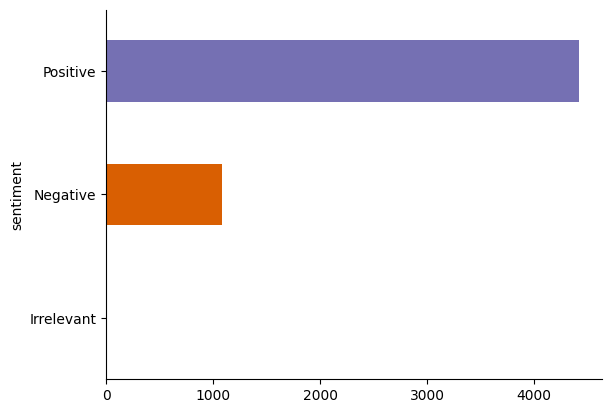

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
dataset.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [26]:
dataset.head()

,campaign_id,comment_id,comment_description,sentiment
0,2212,17908351952371091,\n,0
1,2217,17935944230085744,,1
2,2215S,17899518356507020,This is so good would be great it If you add s...,0
3,2214,18014766136389857,,1
4,2203,17924318627206870,,1


In [30]:
dataset = dataset[(~dataset['comment_description'].isna())]

In [33]:
dataset['comment_description'] = dataset['comment_description'].apply(text_cleaning).tolist()
dataset['sentiment'].replace({'Negative': 0, 'Positive': 1,'Irrelevant':2}, inplace=True)

<ipython-input-5-96706129c615>:4: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

<ipython-input-5-96706129c615>:4: MarkupResemblesLocatorWarning:

The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.



In [28]:
!pip install emoji
import emoji

In [31]:
dataset['comment_description'] = dataset['comment_description'].apply(lambda x: emoji.demojize(x))

In [35]:
df_train, df_test = train_test_split(dataset, test_size = 0.3)

df_val, df_test = train_test_split(df_test, test_size = 0.5)

print(df_train.shape, df_val.shape, df_test.shape)

(3847, 4) (825, 4) (825, 4)


In [41]:
Reviews = df_train['comment_description']
Target = df_train['sentiment']

In [39]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [40]:
max_len= 128
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(df_train.comment_description.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(df_val.comment_description.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(df_test.comment_description.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

In [42]:

k = 0
print('Training Comments -->>',Reviews[k])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])
print('\nLabels -->>',Target[k])

Training Comments -->>            raisedbackofhand
 smilingfacewithhearts

Input Ids -->>
 tf.Tensor(
[  101  6933 12172   102     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0], shape=(128,), dtype=int32)

Decoded Ids -->>
 [CLS] cryingface [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [43]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
# Compile the model with an appropriate optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

ValueError: Could not interpret optimizer identifier: <keras.src.optimizers.adam.Adam object at 0x78dac0458730>

In [47]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification

In [48]:
optimizer = 'adam'

In [49]:
# Compile the model with an appropriate optimizer, loss function, and metrics
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:

# Step 5: Train the model
history = model.fit(
    [X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
    Target,
    validation_data=(
      [X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],df_val.sentiment),
    batch_size=32,
    epochs=3
)

Epoch 1/3
 34/121 [=======>......................] - ETA: 1:05:58 - loss: 0.5108 - accuracy: 0.7781